Продолжим совершенствовать код для соревнования [Catch Me If You Can](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2).

Как работать с малыми данными, мы разбирали на семинаре. Но что делать, когда данных очень много, как у нас в части признаков про посещенные сайты?
Мы можем, например, постараться уменьшить размерность признаков и обучить модели на урезанных представлениях данных.

В этом блокноте разберем два метода TruncatedSVD и MiniBatchKMeans, предназанченные для работы с большими данными и вы увидите, как комфортно ими пользоваться. Для контраста можете запустить тот же KMeans и проверить время работы обоих алгоритмов.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import save_npz, load_npz
from sklearn.metrics import silhouette_score

%matplotlib inline

In [2]:
# Когда вы создали site1 и ttest в прошлом ноутбуке,
# То вы можете сохранить матрицы, чтобы каждый раз их не пересчитывать:
# save_npz('data.npz', site1)
# save_npz('test.npz', ttest)

# Загрузка осуществляется с помощью метода:
site1 = load_npz('data.npz')
ttest = load_npz('test.npz')

In [3]:
from sklearn.decomposition import TruncatedSVD
# Этот метод является PCA для sparse данных
# Из доков: Contrary to PCA, this estimator does not center the data 
# before computing the singular value decomposition. 
# This means it can work with scipy.sparse matrices efficiently.

In [6]:
svd = TruncatedSVD(n_components=500, random_state=42)
svd.fit(site1) #обучаем модель

TruncatedSVD(algorithm='randomized', n_components=500, n_iter=5,
       random_state=42, tol=0.0)

In [7]:
print(svd.explained_variance_ratio_.sum())
# Попробуйте 500 или 1000 n_components у алгоритма, чтобы сохранить до 90% дисперсии
# В конце ноутбука приведен скор на лидерборде при 100 компонентах и при 1000.
# Спойлер - при тысяче лучше.

0.8375680424327407


In [8]:
svd_train = svd.transform(site1) #применяем изменение
svd_test = svd.transform(ttest) #применяем изменение

In [9]:
data = pd.read_csv('../data/Alice/train_sessions.csv')

In [10]:
target = data['target']

In [11]:
from sklearn.cluster import MiniBatchKMeans
# Попробуем специальный метод кластеризации для больших данных
# Можете попробовать и другие, но ожидайте, что работать они будут долго

In [12]:
Ks = range(1, 25)
score = [MiniBatchKMeans(n_clusters=i, random_state=42).fit(svd_train).inertia_ for i in Ks]

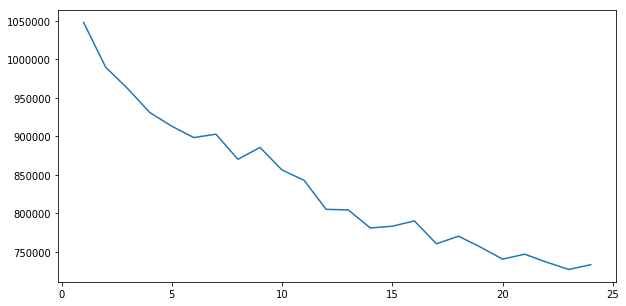

In [13]:
fig = plt.figure(figsize=(10, 5))
plt.plot(Ks, score)

In [14]:
clst = MiniBatchKMeans(n_clusters=20, random_state=42)
clst.fit(svd_train)
pred = clst.predict(svd_train)
pred_test = clst.predict(svd_test)

In [15]:
svd2 = TruncatedSVD(n_components=2, random_state=42)
svd2.fit(svd_train) #обучаем для визуализации

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=42, tol=0.0)

In [16]:
res = svd2.transform(svd_train)
res_test = svd2.transform(svd_test)

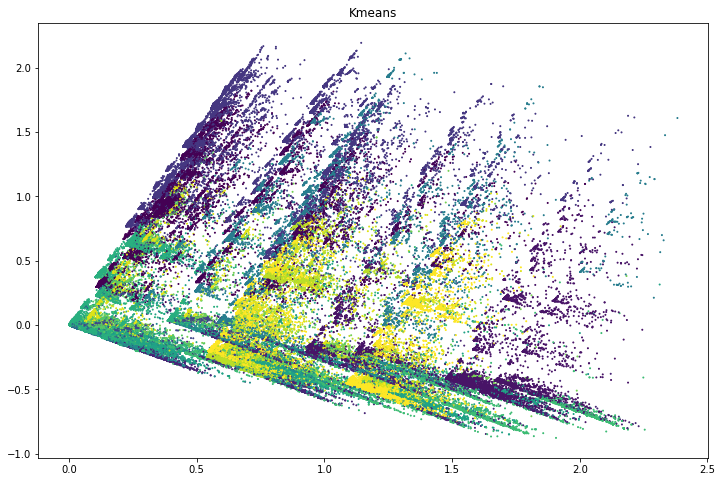

In [17]:
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=pred, s=1, cmap='viridis')
plt.title('Kmeans')
plt.show()

Text(0.5, 1.0, 'Real')

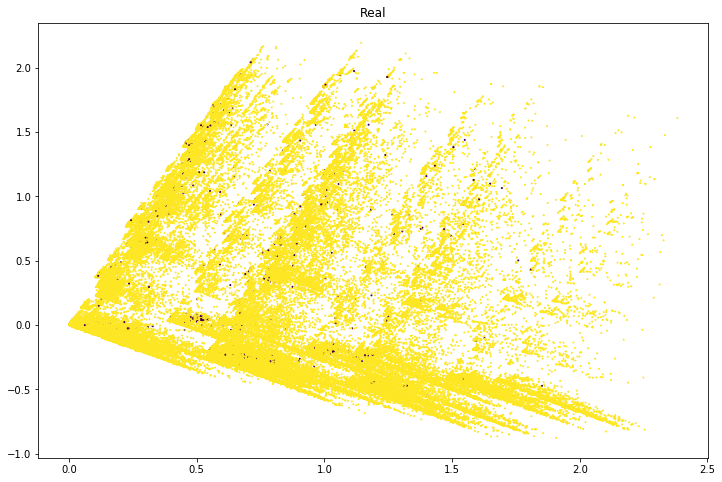

In [18]:
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=target, s=1, cmap='viridis_r')
plt.title('Real')

Text(0.5, 1.0, 'Test')

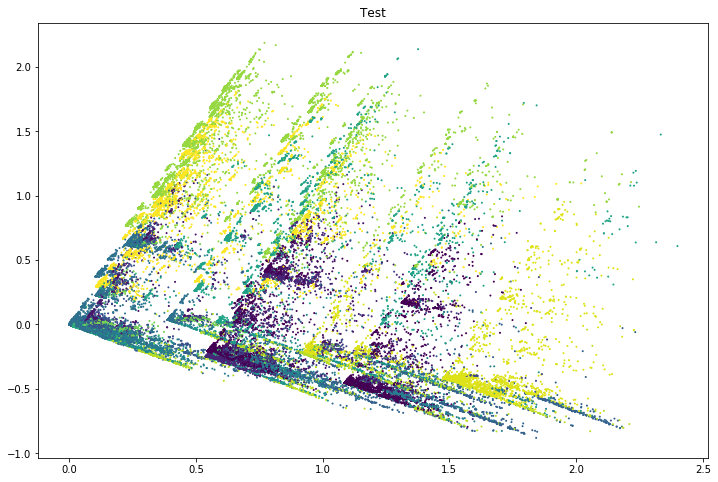

In [19]:
# Для теста

plt.figure(figsize=(12,8))
plt.scatter(res_test[:,0], res_test[:,1], c=pred_test, s=1, cmap='viridis_r')
plt.title('Test')

In [20]:
# Так сразу и не понять, есть ли что-то полезное в кластеризации.
# Поэтому попробуем взять наши признаки из TruncatedSVD и Kmeans и построить случайный лес.

In [21]:
train = np.concatenate((svd_train, np.array(pred).reshape(-1, 1)), axis=1) 
test = np.concatenate((svd_test, np.array(pred_test).reshape(-1, 1)), axis=1)
# Объединяем признаки

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as auc
from sklearn.model_selection import KFold
import time

In [23]:
#обучаем с кросс-валидацией случайный лес
#предсказываем 10 раз трейн, дальше усредним
answ = []
v_metric = []

n=1

kf = KFold(n_splits=10, shuffle=True, random_state=777)   
for tr_ind, val_ind in kf.split(train):
    print('Start {} fold'.format(n))

    val = train[val_ind]
    ttt = train[tr_ind] 

    start_time = time.time()
    clf = RandomForestClassifier(n_estimators=400, 
                                 min_samples_split=10, 
                                 max_depth=8, 
                                 n_jobs=-1, )

    clf.fit(ttt, data['target'][tr_ind].reset_index(drop=True)) 

    model_pred_valid = clf.predict_proba(val)[:, 1]

    y_valid = data['target'][val_ind].reset_index(drop=True)
    valid_metric = auc(y_valid, model_pred_valid)
    v_metric.append(valid_metric)

    print('fold score:', valid_metric, round((time.time() - start_time)/60, 2))
    model_pred = clf.predict_proba(test)[:, 1]
    answ.append(model_pred)

    n+=1

    print('crossval score:', np.mean(v_metric), 'std', np.std(v_metric))
    print('---------------------------------------')

Start 1 fold
fold score: 0.8380707624499449 16.77
crossval score: 0.8380707624499449 std 0.0
---------------------------------------
Start 2 fold
fold score: 0.8242539606664846 18.65
crossval score: 0.8311623615582148 std 0.006908400891730171
---------------------------------------
Start 3 fold
fold score: 0.8525483798230604 377.0
crossval score: 0.8382910343131633 std 0.011552198308036311
---------------------------------------
Start 4 fold
fold score: 0.841199087448272 23.12
crossval score: 0.8390180475969404 std 0.010083432414387132
---------------------------------------
Start 5 fold
fold score: 0.8649362672927196 42.06
crossval score: 0.8442016915360963 std 0.013741220664707983
---------------------------------------
Start 6 fold
fold score: 0.8804651211928063 13.87
crossval score: 0.8502455964788812 std 0.018438950329414165
---------------------------------------
Start 7 fold
fold score: 0.8827447551348186 579.16
crossval score: 0.8548883334297294 std 0.0205122945853178
---------

In [24]:
#собираем предсказания теста
answ_df = pd.DataFrame()
for i in range(len(answ)):
    answ_df['an'+str(i)] = answ[i]
answ_df['answer'] = answ_df.mean(axis=1)

In [25]:
answ_df.head()

,an0,an1,an2,an3,an4,an5,an6,an7,an8,an9,answer
0,0.007108,0.006796,0.006386,0.007450,0.006478,0.006766,0.007172,0.006498,0.006462,0.006817,0.006793
1,0.004085,0.004079,0.004085,0.004176,0.004154,0.004079,0.004210,0.004217,0.004267,0.004215,0.004157
2,0.004777,0.004626,0.004716,0.004745,0.004781,0.004835,0.004656,0.004796,0.004847,0.005097,0.004788
3,0.005399,0.005481,0.005712,0.005663,0.005744,0.005474,0.005401,0.005638,0.005644,0.005380,0.005554
4,0.006144,0.005509,0.006183,0.006360,0.005805,0.005895,0.006021,0.006129,0.005613,0.006592,0.006025


In [26]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [27]:
y_test = np.array(answ_df['answer'])

In [28]:
write_to_submission_file(y_test, 'submission_tree2.csv')

* 100  components, score: 0.85509
* 1000 components, score: 0.88471

Скорее всего, если по сетке подбирать параметры, то можно еще выше скор получить.


### Задание. Срок 5 декабря.

* Какие методы уменьшения размерности и кластеризации предназначены для работы с большими данными (больше нескольких десятков тысяч строк)?
* Сравните на текущих спарс данных насколько по-разному работают предназначенные и нет для больших данных методы уменьшения размерности и кластеризации.
* Подберите гиперпараметры моделей (того же RandomForest) так, чтобы получить модель лучше по кросс-валидации и скору на лб.
* Почему линейная модель показывает себя лучше (если показывает)?